<center>Национальный исследовательский университет ИТМО<br/>Факультет информационных технологий и программирования<br/>Прикладная математика и информатика</center>

## <center>**Методы оптимизации**</center>
### <center>Отчёт по лабораторной работе №3</center>

<div style="text-align: right"><b>Работу выполнили:</b><br/>Левицкий Иван M32351<br/>Шпрайдун Лев M32351<br/>Рынк Артур М32351<br/><b>Преподаватель:</b><br/>Ким С.Е.</div>

<center>Санкт-Петербург<br/>2023</center>

#**Постановка задачи и цели работы:**

№1.1) Реализовать методы Gauss-Newton и Powell Dog Leg для решения нелинейной регрессии.

№1.2) Сравнить эффективность c методами реализованными в предыдущих работах.

№2.1) Реализовать метод BFGS и исследовать его сходимость при минимизации различных функций.

№2.2) Сравнить с другими реализованными методами.

**Работа выполнена при помощи следующих библиотек:**

 1) numpy (в основном для упрощения операций над матрицами и массивами)

 2) matplotlib.pyplot для отрисовки графиков

 3) numdifftools для взятия якобианов, градиентов и гессианов.

 4) scipy для использования одномерного поиска на основе условий Вольфа

In [ ]:
from functools import *
import matplotlib.pyplot as plt

import numpy as np
from numpy.ma.core import shape

!pip install numdifftools
import numdifftools as nd

import scipy as sp

import tqdm
plt.rcParams["figure.figsize"] = (10, 5)



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 3.5 MB/s eta 0:00:00


In [ ]:
#Отрисовка
def print_example_work(x, y, f, b, title="", custom_plt=plt):
  a = np.linspace(np.min(x), np.max(x), 100)
  b = f(a, b)
  custom_plt.plot(a, b)
  custom_plt.scatter(x, y)

  custom_plt.set_xlabel("ось X")
  custom_plt.set_ylabel("ось f(X)")
  custom_plt.set_title(title)

In [ ]:
def print_gradient_work(points, f, num=25, title="", custom_plt=plt):
  x = np.linspace(np.min(points[:, 0]) - 0.01, np.max(points[:, 0]) + 0.01, num)
  y = np.linspace(np.min(points[:, 1]) - 0.01, np.max(points[:, 1]) + 0.01, num)
  X = np.meshgrid(x, y)
  f_res = [[0 for i in range(num)] for j in range(num)]
  for i in range(num):
    for j in range(num):
      f_res[i][j] = f(np.array([x[j], y[i]]))

  custom_plt.contourf(X[0], X[1], f_res)
  custom_plt.plot(points[:, 0], points[:, 1], 'o-', color=(0.8, 0.3, 0.2))
  custom_plt.set_title(title)

##**Нелинейная регрессия**

**Нелинейная регрессия** в общем виде - некоторая последовательость пар $(x_i, y_i)$, задающих с какой-то дисперсией функцию $f$ произвольного вида $f(X, b) = [f_i(x_i)]$, где $x_i \in X \subset R^m, y_i \in Y \subset R^m$, $b \in R^n$, то есть $y_i=f_i(x_i, b)+r_i$.

В более нужном для решении виде это можно записать по-другому $r(b) = error = f(X, b) - Y$, где $b$ - вектор коэффициентов, а $(X, Y)$ - датасет точек.

В таком виде удобно записывается функция ошибок $S(b) = \sum_{i=0}^m{(f_i(x_i, b) - y_i)^2} = \sum_{i=0}^m{r_i^2(b)}$.

###**№0) Реализации методов из предыдущих ЛР для решения нелинейной регрессии.**

####**GD с одномерным поиском - для решения нелинейной регрессии.**

Из 1-ой ЛР возьмем градиентный спуск с линейной оптимизацией на основе дихотомии.

Т.к. он решает задачу минимизации ф-ции (а по заданию нам нужно аппроксимировать нелинейную регрессию), нам нужно давать ему на вход просто ф-цию потерь ($losts$) $S(b) = \sum_i{r_i^2(b)}$

Как мы знаем задача оптимизации функции потерь (в частности $MSE$) равносильна решению регрессий, а значит наш градиентный спуск будет искать нужный вектор коэффициентов исходной ф-ции.

In [ ]:
####Решение нелинейной регрессии с помощью обычного градиентного спуска (с одномерной оптимизацией на основе дихотомии).


##########################Градиентный спуск с одномерной оптимизацией на основе дихотомии (скопировано с ЛР1).

def print_gradient_work_lin_search(points, f, start_linspace, stop_linspace, num, custom_plt=plt):
  custom_plt.plot(points[:, 0], points[:, 1], 'o-')
  print(points)
  t = np.linspace(start_linspace, stop_linspace, num)

  X = np.meshgrid(t, t)
  custom_plt.contour(X[0], X[1], np.vectorize(f)(X), levels=np.sort(np.concatenate((f(points.T), t))))



def bin_search_lr(g, alp, eps, max_count):
  right = 100 ###100
  left = 0
  count = 0
  while right - left > eps and count < max_count:
    count += 1
    medium = (right + left) / 2
    a = medium - alp
    b = medium + alp
    if (g(a) > g(b)):
      left = a
    else:
      right = b
  return left

def gradient_descent_with_bin_search(
    f, start_arg, epochs, max_lr = 100, alp = 0.0001, eps_search = 0.001, max_count = 100,
    eps_stop=1e-5, flag=False, is_plot = False, start_linspace=-1, stop_linspace=1, num=25, custom_plt=plt
     ):

  #отрисовка
  cur = start_arg
  f_array = [f(cur)]

  points = [cur]
  gradient_function = nd.Gradient(f)
  i=0
  while(i < epochs and (i == 0 or abs(f(cur)) > eps_stop)):
    gr = gradient_function(cur)
    g = lambda lr : f(cur - lr * gr)
    if not flag:
      cur = cur - sp.optimize.line_search(f, gradient_function, cur, -gr)[0] * gr
    else:
      cur = cur - bin_search_lr(g, alp, eps_search, max_count) * gr

    #отрисовка
    points.append(cur.copy())
    f_array.append(f(cur))

    i+=1
  if is_plot:
    print_gradient_work(np.array(points), f, custom_plt=custom_plt, title="Gradien decent with binsearch")
  return cur, i, f_array

########################################################


def solve_not_linear_regression_with_gradient_descent(f, X, Y, b, epochs, eps_stop, is_plot=False, custom_plt=plt, flag=False):
  ones = np.ones(len(X))
  S = lambda cur_b : sum((f(X, cur_b) - Y) ** 2)
  return gradient_descent_with_bin_search(S, b, epochs, eps_stop=eps_stop, is_plot=is_plot, custom_plt=custom_plt,flag=flag)



####**SGD(Adam) - для решения нелинейной регрессии.**

Из 2-ой ЛР возьмем $SGD$ (а точнее его лучшею оптимизацию $Adam$).

Т.к. он решает задачу линейной регрессии (а по заданию нам нужно аппроксимировать нелинейную регрессию), нам нужно делать пересчет функции потерь вдоль ф-ции $f$ вместо общего вида прямой $y = kx + b, (H(k, b) = kx + b - y)$.

Таким образом фунция потерь $H$ просто примет форму $H(b) = \frac{1}{m} ⋅ \sum_i^m{(f(X, b) - Y)^2_i}$.

А также нам нужно будет заменить батч на максимальный так как иначе слишком тяжело брать производную по нужным переменным и все время пересчитывать $r_i$.


In [ ]:
####ADAM (из ЛР2 перестроенный для решения нелинейной регрессии)



##SGD_PROTOTYPE
#batch - max

def H(f, X, Y, W):
  m = Y.shape[0]
  return sum((f(X, W) - Y) ** 2)

def gradH(f, gradF, X, Y, W):
  m = Y.shape[0]
  return 1/m * 2 * (f(X, W) - Y) @ gradF(W)

def SGD_prototype(f, X, Y, W, lr, change_W, change_lr, epochs,
                  change_G = 0,
                  change_V = 0,
                  beta_1 = 0, beta_2 = 0, eps_stop = -1):
  cur_epoch = 0
  n = len(X)
  v = W
  g = W

  ###отрисовка
  weights_paint=[W.copy()]
  losts=[H(f, X, Y, W)]
  ###

  while (cur_epoch <= epochs and (eps_stop == -1 or H(f, X, Y, W) > eps_stop)):
    cur_epoch+=1

    #доп последовательности
    if change_V != 0:
      v = change_V(v, beta_1, lr, W, X, Y)
    if change_G != 0:
      g = change_G(v, g, beta_2, W, X, Y)

    #пересчет
    W = change_W(X, Y, W, v, g, lr)
    lr = change_lr(lr, cur_epoch)

    #для отрисовки
    weights_paint.append(W.copy())
    losts.append(H(f, X, Y, W))
  # W = [W[0].tolist(), W[1]]
  return W, weights_paint, losts, cur_epoch

########ADAM

def SGD_Adam(f, X, Y, W, lr, epochs = 100, beta_1 = 0.9, beta_2 = 0.99, eps_stop=-1):
  gradient_function = nd.Gradient(lambda b0 : f(X, b0))
  change_V = lambda v, beta_1, lr, W, X_i, Y_i : beta_1 * v + (1 - beta_1) * gradH(f, gradient_function, X_i, Y_i, W)
  change_G = lambda v, g, beta_2, W, X_i, Y_i : beta_2 * g + (1 - beta_2) * (gradH(f, gradient_function, X_i, Y_i, W) ** 2)
  change_W = lambda X_i, Y_i, W, v, g, lr : W - (lr / np.sqrt(g + 1e-8)) * v
  return SGD_prototype(f, X, Y, W, lr, change_W, (lambda lr, epochs : lr), epochs,
                       change_G=change_G, change_V=change_V, beta_1=beta_1, beta_2=beta_2, eps_stop=eps_stop)


###**№1.1) Реализация новых методов решения нелинейной регрессии**

Основная идея состоит в том, что мы мы можем аппроксимировать всю модель линейной функцией, а именно $f(x_i, b) \approx f_0 + \sum_j{J_{ij}b_j}$, где $J-$якобиан ф-ции $f(X, b)$.

$⇔ b \approx (J^TJ)^{-1} \cdot r(b)$

Статистика нелинейной регрессии вычисляется и используется как статистика линейной регрессии, но вместо $X$ в формулах используется $J$. Линейная аппроксимация вносит смещение в статистику, поэтому следует более осторожно интерпретировать статистики, полученные из нелинейной модели.

####**Gauss-Newton**

Чтобы разобраться в методе Гаусса-Ньютона нужно обратиться к методу Ньютона.

Суть метода Ньютона в финальной итерации $b_{k+1} = b_k - \frac{f'(X,\ b_k)}{f''(X,\ b_k)} \Leftrightarrow b_{k+1} = b_k - H^{-1} \cdot J^T \cdot r(b_k)$. То есть для пересчета ему постоянно требуется вычисление Гессиана (матрицы вторых производных). Это очень трудоемкий процесс (и к тому же ведет к расхождению или сбою работы алгоритма если вторые производные близки к нулю).

Алгоритм Гаусса-Ньютона отказывается от счета вторых производных и считает только первые ($J$), и совершает чуть более огрубленный пересчет, за счет еще одной аппроксимации:

$H_{jk} ≈ 2 ⋅ \sum_{i=1}^m{J_{ij}J_{ik}} ⇔ H^{-1} \approx (J^TJ)^{-1}$

 $b_{k + 1} = b_k + (J^TJ)^{-1}r(b_k)$

 Также можно стандартным образом добавлять коэффициент $α$ к пересчету точки.

 **Итоговая формула итерации Гаусса-Ньютона:**

 $b_{k + 1} = b_k + α(J^TJ)^{-1}J^Tr(b_k)$


Потенциальные ошибки (причины расхождения):

1) Начальное приближение выбрано неправильно. Метод достаточно зависим от начальных точек.

2) Якобиан не имеет обратной матрицы, т.е. если матрица Якоби вырождена или близка к вырожденной.

3) В целом плохая обусловленность модели.

In [ ]:
####Gauss-Newton

# def funJ1(X, b):
#   j1 = X / (b[1] + X)
#   j2 = -(b[0] * X) / (b[1] + X) ** 2
#   return np.array([j1, j2]).T

def method_Gauss_Newton(f, X, Y, b0, epochs, eps_stop=0, alpha=1):
  b = b0

  Jf = nd.Jacobian(lambda B : f(X, B))
  cur_epoch = 0

  #отрисовка
  points = [b.copy()]
  s_array = [sum((Y - f(X, b)) ** 2)]

  while (cur_epoch < epochs):
    cur_epoch += 1

    J = Jf(b)
    r = (Y - f(X, b))
    d = (np.linalg.inv(J.T @ J) @ J.T @ r)
    s = sum((Y - f(X, b)) ** 2)
    if (s < eps_stop):
      break

    b += alpha * d

    points.append(b.copy())
    s_array.append(s.copy())
  return b, points, s_array, cur_epoch


####**Powell DogLeg**

Метод Powell DogLeg (оптимизация алгоритма TrustRegion опирающаяся на алгоритм Гаусс-Ньютона) основан на постоянном выборе фундаментально нового направления шага (картинка ниже).

В текущей точке (в реализации $b_{k-1}$) $x_{k-1}$ мы рассматриваем взаимное расположение векторов $tδ_{sd}$ и $\delta_{gn}$ и окружности радиуса $delta_k=Δ_k$

 (где $t\delta_{sd}-$направление градиента, $\delta_{gn}-$направление в итерации алгоритма Гаусс-Ньютона, $t = \frac{\|\delta_{sd}\|^2}{\|Jδ_{sd}\|^2}$)

**Всего возможно 3 варианта (сама оптимизация DogLeg)**:

1) $δ_{gn} < Δ_k$ То есть оба вектора внутри и тогда мы выбираем шаг $p = δ_{gn}$

2) $δ_{gn} > Δ_k \ \& \ t\|δ_{sd}\| > Δ_k$ То есть оба вектора снаружи и тогда мы берем шаг $p=Δ_k \cdot tδ_{sd}$

3) $δ_{gn} > Δ_k \ \& \ t\|δ_{sd}\| < Δ_k$ То есть один вектор снаружи другой внутри - тогда мы берем точку с окружности такую что она лежит на пересечении окружности и вектора соединяющего концы изначальных. Итого: $p=tδ_{sd} + s\cdot(δ_{gn} - tδ_{sd})$, где s - такое число что $\|p\|=Δ_k$ (находится решая квадратное уравнение).

**Далее происходит пересчет** $x_k=x_{k-1} + p$.

А также пересчет радиуса, ведь на самом деле у нас происходит минимизация ф-ции $m_k(p) = f(x_k) + p^TΔf(x_k) + \frac{1}{2}p^TΔ^2f(x_k)\cdotp$

И мы в зависимости от отношений предсказанной разницы и реальной меняем радиус (как в дефолтном $trust-region$)

Скажем, что $ρ_k=\frac{f(x_k) - f(x_{k+1})}{m_k(0)-m_k(p)}$ - отношение реального к предсказанному.

 **Далее опять же 3 случая пересчета:**

1) $ρ_k < \frac{1}{4}$ - тогда $Δ_{k+1} = \frac{Δ_k}{4}$

2) $\frac{1}{4}< ρ_k < \frac{3}{4}$ или $\ \|p\| \not=Δ_k$ - тогда $Δ_{k+1} = Δ_k$

3) $\frac{3}{4} > ρ_k$ и $\|p\| =Δ_k$ - тогда $Δ_{k+1} = min(2Δ_k, Δ_{max})$




Powell_dog_leg.svg

In [ ]:
####Powell-Dog-Leg

def method_Powell_Dog_Leg(f, X, Y, b0, delta_start, epochs, eps_stop=0, alpha=1, delta_max=100):
  b = b0
  delta = delta_start

  #Якобиан
  Jf = nd.Jacobian(lambda B : f(X, B))

  #Функция потерь (MSE)
  S = lambda B : sum((f(X, B) - Y) ** 2)

  gradS = nd.Gradient(S)

  M = lambda p : S(b) + p.T @ gradS(b) + 0.5 * (delta ** 2) * S(b) * (p.T @ p)

  cur_epoch = 0

  #отрисовка
  points = [b.copy()]
  s_array = [sum((y - f(X, b)) ** 2)]

  while (cur_epoch < epochs):
    cur_epoch += 1

    #Якобиан
    J = Jf(b)

    r = (Y - f(X, b))

    #рассматривыемые вектора
    sd = J.T @ r
    gn = np.linalg.inv(J.T @ J) @ sd

    ####


    #########PDL-оптимизация Trust-Region
    d = 0
    #разбор случаев взаимного расположения векторов относительно окружности радиуса дельта

    if (np.linalg.norm(gn) <= delta): # оба вектора внутри окружности
      # print("ququ1")
      d = gn
    else:
      norm_sd = np.linalg.norm(sd)
      t = (norm_sd / np.linalg.norm(J @ sd)) ** 2
      tsd = t * sd

      if (t * norm_sd > delta):
        # print("ququ2")
        d = delta * tsd / np.linalg.norm(tsd)
      else:
        # print("ququ3")
        sub = gn - tsd
        norm_sub = sub @ sub.T
        dot_gu_sub = gn @ sub.T
        f_koef = dot_gu_sub ** 2 - norm_sub * ((t * norm_sd) ** 2 - delta ** 2)
        d = tsd + ((-dot_gu_sub + np.sqrt(f_koef)) / norm_sub) * sub
        # print(d)
    ##################


    act_red = S(b) - S(b + alpha * d)
    s = sum((Y - f(X, b)) ** 2)
    pred_red = M(np.zeros(len(b))) - M(d)

    k = 0
    if (pred_red == 0.0):
      k = 1e90
    else:
      k = act_red / pred_red

    if (k < 0.25):
      delta = 0.25 * np.linalg.norm(d)
    elif (k > 0.75 and np.linalg.norm(d) == delta):
      delta = min(2 * delta, delta_max)

    if (s < eps_stop):
      break

    b += alpha * d

    points.append(b.copy())
    s_array.append(s.copy())

  return b, points, s_array, cur_epoch



###**Примеры работы методов решения нелинейной регрессии**

Стандартный генератор регрессии (с рандомизированным разбросом аргументов, значений и ошибок)

In [ ]:
###генерация

def gen_random_points_y(f, b_real, X, disp=0.1):
  y = []
  Y_real = f(X, b_real)
  for i in range(0, len(X)):
    y.append(Y_real[i] + np.random.rand() * disp)

  return np.array(y)


def gen_random_points_f(f, b_real, count, dispx=5, disp=0.01, shiftx=0.0):
  X = np.random.rand(count) * (dispx - shiftx) + shiftx
  return X, gen_random_points_y(f, b_real, X, disp)



###**Серия экспериментов 1**

В этой серии (4-мя вышеописанными методами) будем пытаться решить нелинейные регрессии сгенерированные относительно различных функций размерности 2 по вектору коэффициентов.

За счет низкой размерности мы одновременно посмотрим на:

**1) отрисовку восстановленной ф-ции относительно исходной регрессии**

**2) график поиска точки (с линиями уровня)**


**Эксперимент 1)**

$f(x, b) = \frac{x \cdot b_0}{b_1 + x}$

Стартовая точка $b = [0.9, 0.2]$, 5 фиксированных шагов при малом кол-ве точек.

Верным (и здесь единственным) локальным минимумом является точка $b = [0.36, 0.55]$, к которому и успешно приблизились новые алгоритмы.

**Вывод:**

Все алгоритмы справились, но $GD$ найдя приблизительно верно первую координату перескочил через верную точку по другой, $Adam$ с заданной $λ$ делал это слишком медленно хоть и в верном направлении.

Новые алгоритмы показали себя сильно лучше (т.к. смотрят на все координаты сразу в более сложном/общем виде, опираются в своем устройстве как на скорость роста функции, так и на ее гладкость, выпуклость).

[0.36180308 0.55607253] 5
[0.36183003 0.5562274 ] 5
[0.4019782  0.77875871] 5
[0.25487438 0.14237847] 6


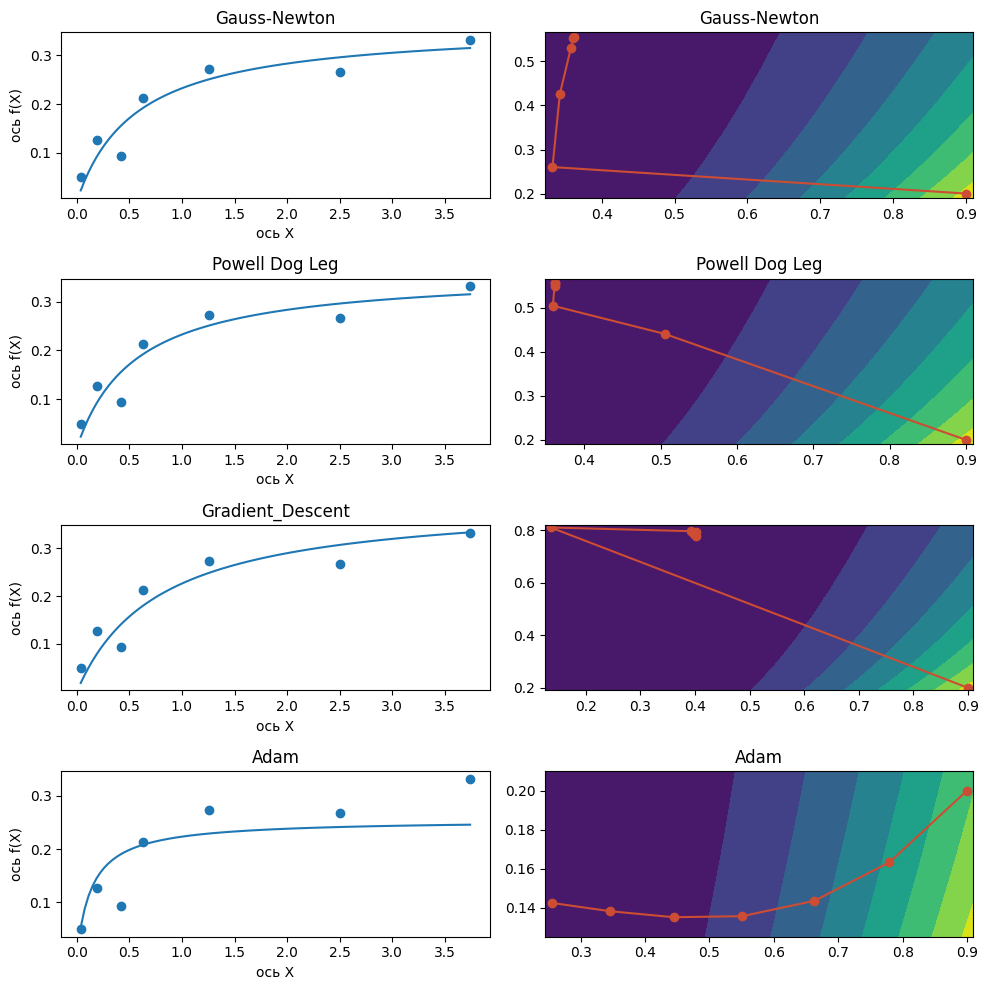

In [ ]:
#1) Функция с википедии

def f1(X, b):
  return ((X * b[0]) / (b[1] + X))

plt.rcParams["figure.figsize"] = (10, 10)
fig, ((ax11, ax12), (ax21, ax22), (ax31, ax32), (ax41, ax42)) = plt.subplots(4, 2)

x1 = np.array([0.038, 0.194, 0.425, 0.626, 1.253, 2.500, 3.740])
y1 = np.array([0.050, 0.127, 0.094, 0.2122, 0.2729, 0.2665, 0.3317])
b01 = np.array([0.9, 0.2])
####
x = x1.copy()
y = y1.copy()
b0 = b01.copy()

b, points, s_array, cur_epoch = method_Gauss_Newton(f1, x, y, b0, 5, 0)
print(b, cur_epoch)

print_example_work(x, y, f1, b, title="Gauss-Newton", custom_plt=ax11)

print_gradient_work(np.array(points), lambda B: sum((y - f1(x, B)) ** 2), title="Gauss-Newton", custom_plt=ax12)

####
x = x1.copy()
y = y1.copy()
b0 = b01.copy()

b, points, s_array, cur_epoch = method_Powell_Dog_Leg(f1, x, y, b0, 0.5, 5, 0)
print(b, cur_epoch)

print_example_work(x, y, f1, b, title="Powell Dog Leg", custom_plt=ax21)

print_gradient_work(np.array(points), lambda B: sum((y - f1(x, B)) ** 2), title="Powell Dog Leg", custom_plt=ax22)

####(без копирования проблема со ссылками)
x = x1.copy()
y = y1.copy()
b0 = b01.copy()

b, cur_epoch, _ = solve_not_linear_regression_with_gradient_descent(f1, x, y, b0, 5, 0, is_plot=True, custom_plt=ax32)
print(b, cur_epoch)

print_example_work(x, y, f1, b,  title="Gradient_Descent", custom_plt=ax31)


####
x = x1.copy()
y = y1.copy()
b0 = b01.copy()

W, weights_paint, losts, cur_epoch = SGD_Adam(f1, x, y, b0, 0.13, epochs=5, eps_stop=0.01)

print(W, cur_epoch)

print_example_work(x, y, f1, W,  title="Adam", custom_plt=ax41)

print_gradient_work(np.array(weights_paint), lambda B: sum((y - f1(x, B)) ** 2), title="Adam", custom_plt=ax42)

plt.tight_layout() # Выравнивание


**Эксперимент 2)**

$f(x, b) = sin(x) \cdot b_0 + b_1 ⋅ x$

sin(x) - несколько повышает разбросс точек и, главное, усложняет поведение производных функции.

**Вывод:**

$Powell's DogLeg$ при не самой оптимально подобранной стартовой $Δ_0$ может делать не достаточно оптимальные первые несколько шагов (не по гаусс-ньютону) и дальше сильно замедлять скорость своего схождения.

$GD$ и $Adam$ достаточно сильно проигрывают в точности хотя все еще прдолжают более менее сходится к задуманному локальному минимуму. Траектория Адама вполне соответствует его харрактерному поведению расммотренному в предыдущей ЛР.

[1.26666659 0.3743039 ] 100
[1.26666659 0.3743039 ] 100
[2.34072581 0.57423831] 10
[1.33310742 0.38619883] 101


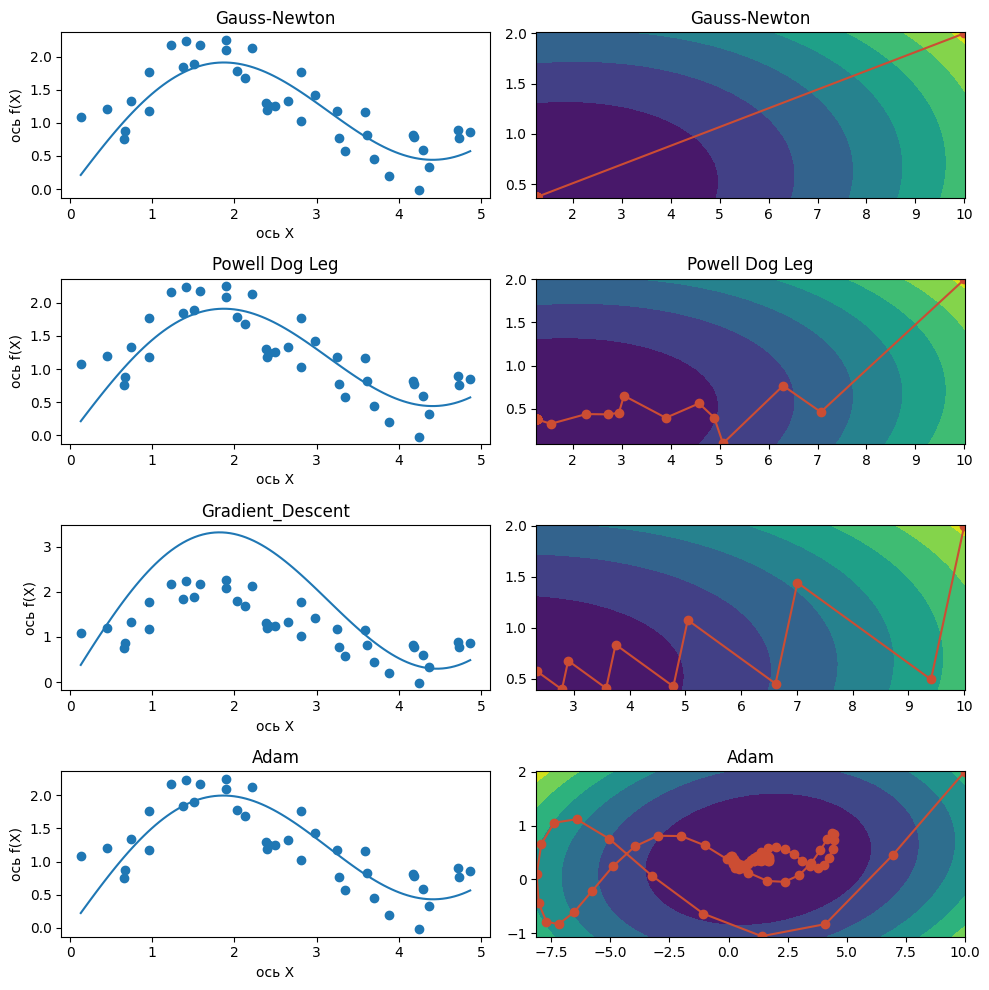

In [ ]:
#2) b1 * sinx + b2 * x (рандомные аргументы)

def f1(X, b):
  return np.sin(X) * b[0] + b[1] * X

plt.rcParams["figure.figsize"] = (10, 10)
fig, ((ax11, ax12), (ax21, ax22), (ax31, ax32), (ax41, ax42)) = plt.subplots(4, 2)

b01 = np.array([10.0, 2.0])
answer = np.array([1.0, 0.2]) #итоговый ответ
x1, y1 = gen_random_points_f(f1, answer, 40, dispx=5, disp=1)


####
x = x1.copy()
y = y1.copy()
b0 = b01.copy()

b, points, s_array, cur_epoch = method_Gauss_Newton(f1, x, y, b0, 100, 0.1)
print(b, cur_epoch)

print_example_work(x, y, f1, b, title="Gauss-Newton", custom_plt=ax11)

print_gradient_work(np.array(points), lambda B: sum((y - f1(x, B)) ** 2), title="Gauss-Newton", custom_plt=ax12)

####
x = x1.copy()
y = y1.copy()
b0 = b01.copy()

b, points, s_array, cur_epoch = method_Powell_Dog_Leg(f1, x, y, b0, 7, 100, 1)
print(b, cur_epoch)

print_example_work(x, y, f1, b, title="Powell Dog Leg", custom_plt=ax21)

print_gradient_work(np.array(points), lambda B: sum((y - f1(x, B)) ** 2), title="Powell Dog Leg", custom_plt=ax22)

####(без копирования проблема со ссылками)
x = x1.copy()
y = y1.copy()
b0 = b01.copy()

b, cur_epoch, _ = solve_not_linear_regression_with_gradient_descent(f1, x, y, b0, 10, 1, is_plot=True, custom_plt=ax32)
print(b, cur_epoch)

print_example_work(x, y, f1, b,  title="Gradient_Descent", custom_plt=ax31)


####
x = x1.copy()
y = y1.copy()
b0 = b01.copy()

W, weights_paint, losts, cur_epoch = SGD_Adam(f1, x, y, b0, 1, epochs=100, eps_stop=1)

print(W, cur_epoch)

print_example_work(x, y, f1, W,  title="Adam", custom_plt=ax41)

print_gradient_work(np.array(weights_paint), lambda B: sum((y - f1(x, B)) ** 2), title="Adam", custom_plt=ax42)

plt.tight_layout() # Выравнивание

**Эксперимент 3)**

$f(x, b) = sin(x) \cdot e^{\frac{x}{b_0}} + b_1x$

**Вывод:**

Здесь уже видно, что $Adam$ находит не тот локальный минимум, что остальные (хоть в итоге соответствующая ему ф-ция и оказывается вполне соответствующей исходной регрессии)

$GD$, $Gauss-Newton$ и $Powell's DogLeg$ находят один и тот же локальный минимум за 100 шагов с приблизительно одинаковой точностью, однако по траектории их спусков видно, что $GD$ справился на удивление лучше (на самом деле это можно объяснить тем, что направление градиента здесь неплохо аппроксимировалось прямой, и спуск по нему сразу же оказался повыгоднее)



[4.59949478 3.56436444] 100
[4.59949478 3.56436444] 100
[4.58633895 3.56505533] 100
[86.09276982  3.44631403] 101


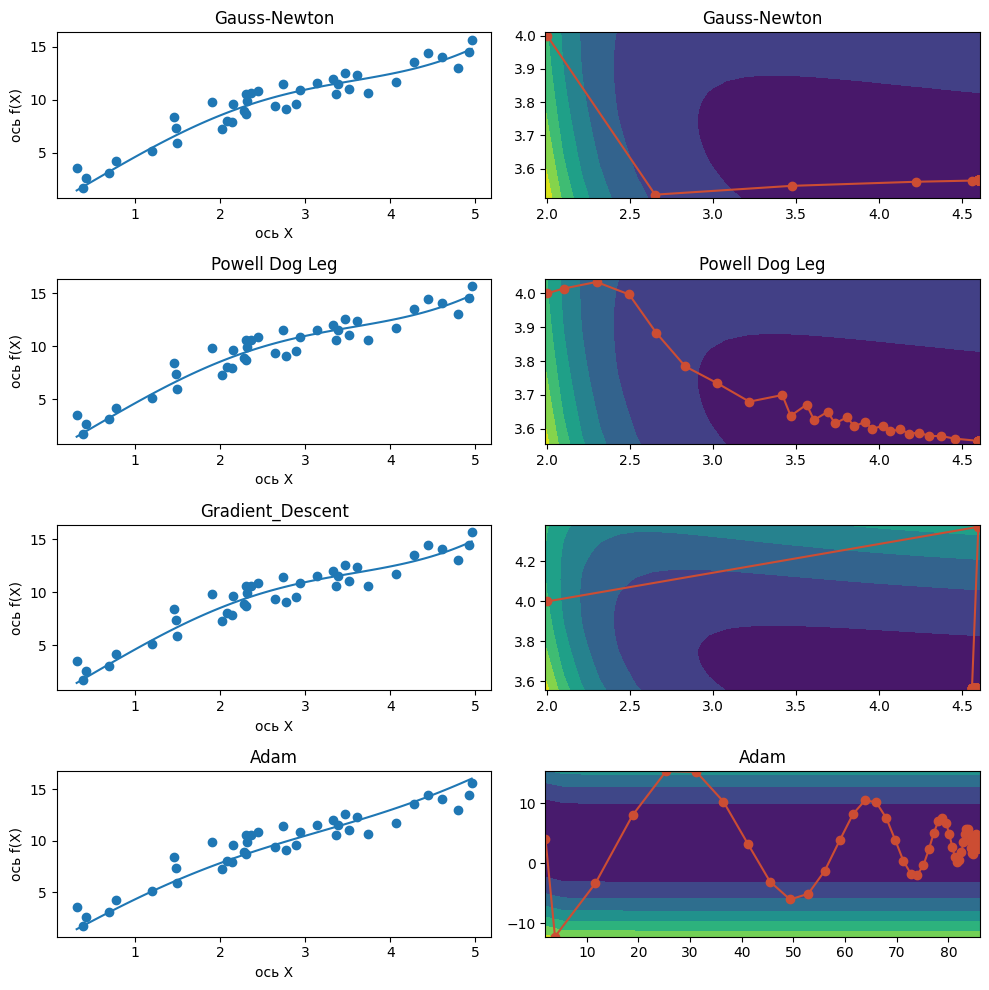

In [ ]:
#3) sinx *e^kx * x (рандомные аргументы)

def f1(X, b):
  return np.sin(X) * np.exp(X/b[0]) + b[1] * X

plt.rcParams["figure.figsize"] = (10, 10)
fig, ((ax11, ax12), (ax21, ax22), (ax31, ax32), (ax41, ax42)) = plt.subplots(4, 2)

b01 = np.array([2.0, 4.0])
answer = np.array([10.0, 3.0]) #итоговый ответ
x1, y1 = gen_random_points_f(f1, answer, 40, dispx=5, disp=3, shiftx=0)

#print(np.sin(x1) * np.exp(b01[0] * x1) * x1)
####
x = x1.copy()
y = y1.copy()
b0 = b01.copy()

b, points, s_array, cur_epoch = method_Gauss_Newton(f1, x, y, b0, 100, 1)
print(b, cur_epoch)

print_example_work(x, y, f1, b, title="Gauss-Newton", custom_plt=ax11)

print_gradient_work(np.array(points), lambda B: sum((y - f1(x, B)) ** 2), title="Gauss-Newton", custom_plt=ax12)

####
x = x1.copy()
y = y1.copy()
b0 = b01.copy()

b, points, s_array, cur_epoch = method_Powell_Dog_Leg(f1, x, y, b0, 0.1, 100, 1)
print(b, cur_epoch)

print_example_work(x, y, f1, b, title="Powell Dog Leg", custom_plt=ax21)

print_gradient_work(np.array(points), lambda B: sum((y - f1(x, B)) ** 2), title="Powell Dog Leg", custom_plt=ax22)

####(без копирования проблема со ссылками)
x = x1.copy()
y = y1.copy()
b0 = b01.copy()

b, cur_epoch, _ = solve_not_linear_regression_with_gradient_descent(f1, x, y, b0, 100, 0.1, is_plot=True, custom_plt=ax32)
print(b, cur_epoch)

print_example_work(x, y, f1, b,  title="Gradient_Descent", custom_plt=ax31)


####
x = x1.copy()
y = y1.copy()
b0 = b01.copy()

W, weights_paint, losts, cur_epoch = SGD_Adam(f1, x, y, b0, 10, epochs=100, eps_stop=0.1)

print(W, cur_epoch)

print_example_work(x, y, f1, W,  title="Adam", custom_plt=ax41)

print_gradient_work(np.array(weights_paint), lambda B: sum((y - f1(x, B)) ** 2), title="Adam", custom_plt=ax42)

plt.tight_layout() # Выравнивание

**Эксперимент 4)**

$f(x, b) = b_0x^3 + b_0b_1x^2$

**Вывод:**

У $Adam$ сохраняется высокая степень неточных шагов, $Gauss-Newton$ и $Powel's DogLeg$ же идут ровными шажками к намеченному локальному минимуму (при этом из-за маленкого $Δ_k$ Powell's DogLeg делает это менее качественно чем Гаусс-Ньютон, однако это в целом снижает вероятность его ошибки)


[ -0.15428688 -16.3588925 ] 100
[0.38888695 3.9863683 ] 100
[0.67527963 1.54745144] 101


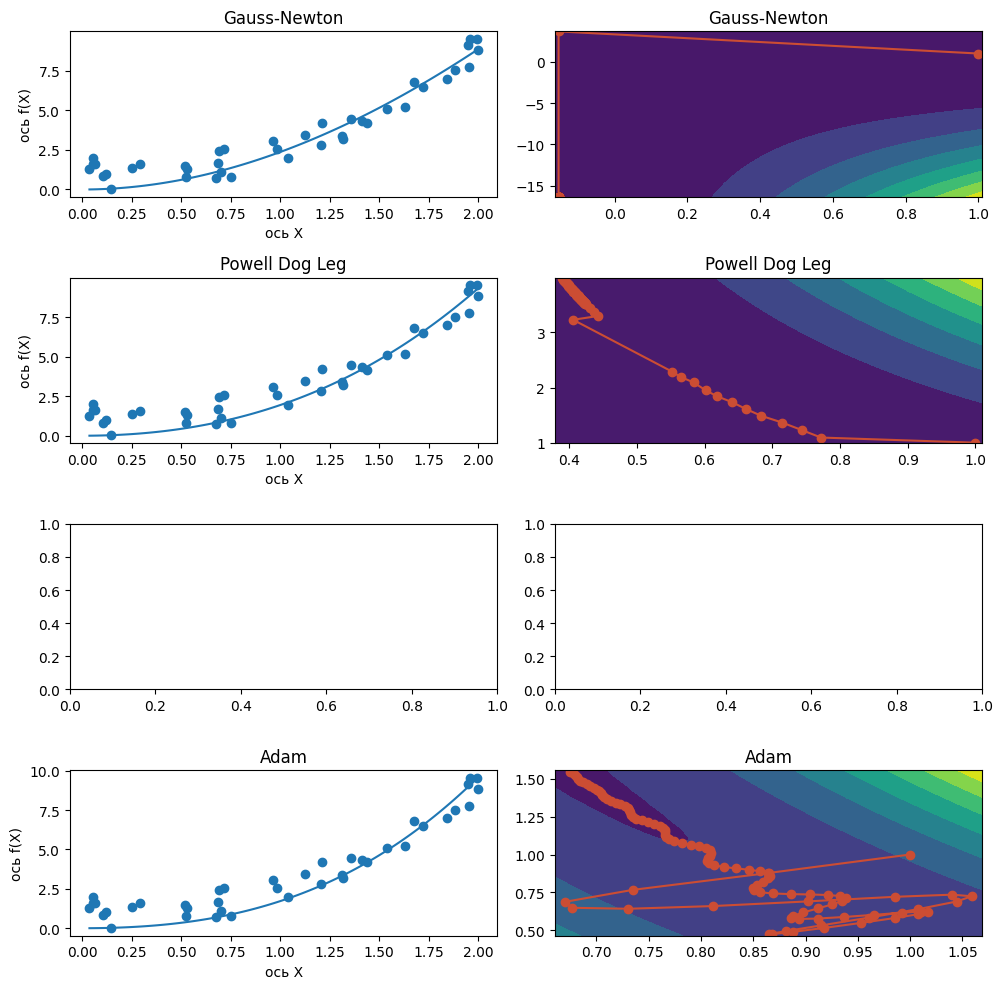

In [ ]:
#4) b[0] * X^3 + b[1] * X^2 (полином)

def f1(X, b):
  return (b[0]) * (X ** 3) + b[0] * b[1] * (X ** 2)

plt.rcParams["figure.figsize"] = (10, 10)
fig, ((ax11, ax12), (ax21, ax22), (ax31, ax32), (ax41, ax42)) = plt.subplots(4, 2)

b01 = np.array([1.0, 1.0])
answer = np.array([0.5, 2.0]) #итоговый ответ
x1, y1 = gen_random_points_f(f1, answer, 40, dispx=2, disp=2, shiftx=0)

#print(np.sin(x1) * np.exp(b01[0] * x1) * x1)
####
x = x1.copy()
y = y1.copy()
b0 = b01.copy()

b, points, s_array, cur_epoch = method_Gauss_Newton(f1, x, y, b0, 100, 1)
print(b, cur_epoch)

print_example_work(x, y, f1, b, title="Gauss-Newton", custom_plt=ax11)

print_gradient_work(np.array(points), lambda B: sum((y - f1(x, B)) ** 2), title="Gauss-Newton", custom_plt=ax12)

####
x = x1.copy()
y = y1.copy()
b0 = b01.copy()

b, points, s_array, cur_epoch = method_Powell_Dog_Leg(f1, x, y, b0, 1, 100, 3)
print(b, cur_epoch)

print_example_work(x, y, f1, b, title="Powell Dog Leg", custom_plt=ax21)

print_gradient_work(np.array(points), lambda B: sum((y - f1(x, B)) ** 2), title="Powell Dog Leg", custom_plt=ax22)

####(без копирования проблема со ссылками)
x = x1.copy()
y = y1.copy()
b0 = b01.copy()

# b, cur_epoch, _ = solve_not_linear_regression_with_gradient_descent(f1, x, y, b0, 10, 3, is_plot=True, custom_plt=ax32)
# print(b, cur_epoch)

# print_example_work(x, y, f1, b,  title="Gradient_Descent", custom_plt=ax31)


####
x = x1.copy()
y = y1.copy()
b0 = b01.copy()

W, weights_paint, losts, cur_epoch = SGD_Adam(f1, x, y, b0, 0.1, epochs=100, eps_stop=0.01)

print(W, cur_epoch)

print_example_work(x, y, f1, W,  title="Adam", custom_plt=ax41)

print_gradient_work(np.array(weights_paint), lambda B: sum((y - f1(x, B)) ** 2), title="Adam", custom_plt=ax42)

plt.tight_layout() # Выравнивание

###**№1.2)Исследование эффективности методов решения нелинейной регрессии**

###**Серия экспериментов 2**

Исследуем зависимость функции потерь $losts$ от текущей эпохи.

Напомним что ф-ция потерь у нас MSE и в принятом формате выражается как:

$H(b) = \sum_{i=0}^m{((f(X, b) - Y)^2)_i}$

####**Эксперимент 1)**

$f(x, b) = b_0x^3 + b_1x^2 - x + 1$

**Вывод:**

Gauss-Newton и Powell's DogLeg имеют характерные "ступеньки" в своей траектории и сходятся быстрее старых методов.

Адам имеет волнообразную траектори и ему очень трудно подобрать такую константу, чтобы диапазон скачков был невысоким.

GD сходится гораздо медленнее новых методов, но на конкретно этом примере быстрее Адама, т.к. ф-ция полином низкой степени и линейный поиск вдоль градиента достаточно эффективен.


[0.45380069 2.10354652] 100
[0.45380069 2.10354652] 100
[0.58197134 1.87372787] 50
[0.63035415 1.78372921] 101


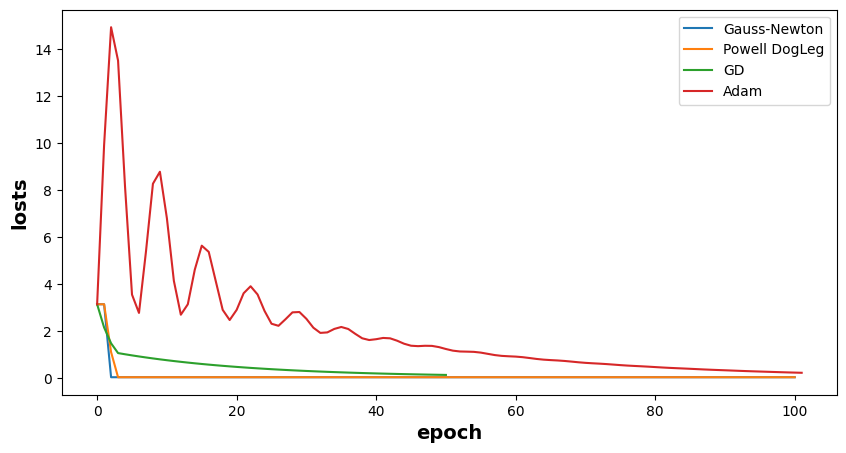

<Figure size 1000x500 with 0 Axes>

In [ ]:
###LOSTS/EPOCH

def f1(X, b):
  return b[0] * (X ** 3) + b[1] * (X ** 2) - X + 1


b01 = np.array([1.0, 1.0])
answer = np.array([0.5, 2.0]) #итоговый ответ
x1, y1 = gen_random_points_f(f1, answer, 20, dispx=2, disp=0.1, shiftx=0)

x = x1.copy()
y = y1.copy()
b0 = b01.copy()

b, points, s_array, cur_epoch = method_Gauss_Newton(f1, x, y, b0, 100, 0)
print(b, cur_epoch)

plt.plot(s_array, label=f"Gauss-Newton")


####
x = x1.copy()
y = y1.copy()
b0 = b01.copy()

b, points, s_array, cur_epoch = method_Powell_Dog_Leg(f1, x, y, b0, 1, 100, 0)
print(b, cur_epoch)
plt.plot(s_array, label=f"Powell DogLeg")

####(без копирования проблема со ссылками)
x = x1.copy()
y = y1.copy()
b0 = b01.copy()

b, cur_epoch, s_array = solve_not_linear_regression_with_gradient_descent(f1, x, y, b0, 50, eps_stop=0.1)
print(b, cur_epoch)
plt.plot(s_array, label=f"GD")


####
x = x1.copy()
y = y1.copy()
b0 = b01.copy()

W, weights_paint, losts, cur_epoch = SGD_Adam(f1, x, y, b0, 0.1, epochs=100, eps_stop=0)

print(W, cur_epoch)
plt.plot(losts, label=f"Adam")



plt.legend()
plt.ylabel("losts", fontsize=14, fontweight="bold")
plt.xlabel("epoch", fontsize=14, fontweight="bold")
plt.show()
plt.tight_layout() # Выравнивание

$f(x, b) = \frac{b_0}{x^3} + \frac{b_1}{x^2} + \frac{b_2}{10x} + \frac{b_3x}{100}$

[  98.35586203 -113.39987162  299.42540397   11.56038131] 100
[11.87495464 11.1626551   1.84316485 12.19614493] 100
[11.67300835 11.35360109  2.28375785 12.21343036] 100
[10.28131063 11.26345921 22.42145881 12.21408141] 101


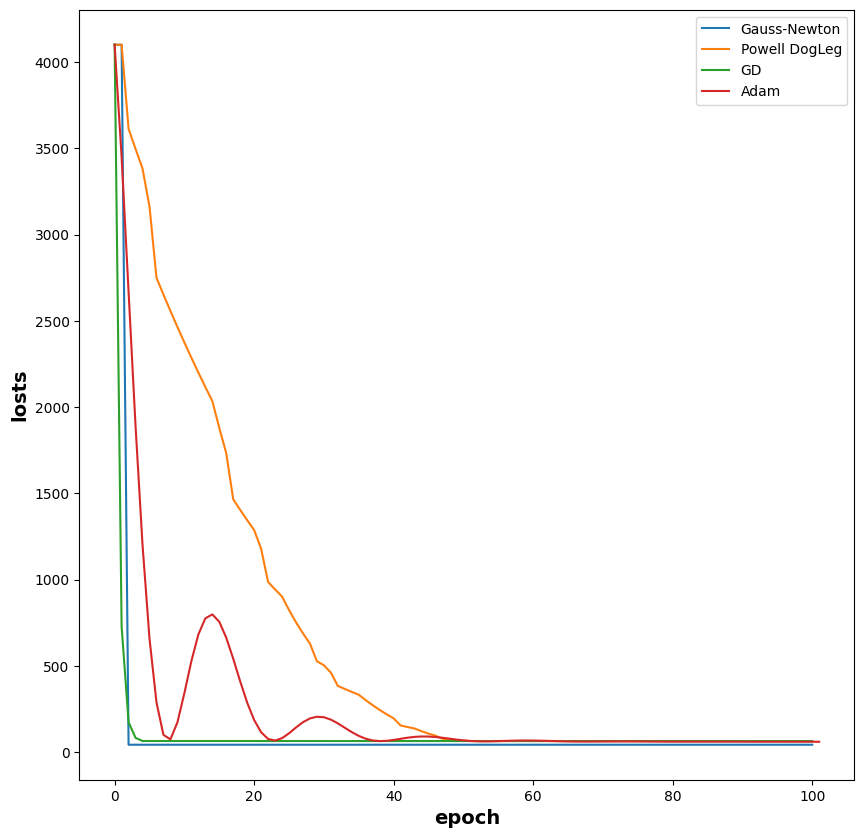

<Figure size 1000x1000 with 0 Axes>

In [ ]:
###LOSTS/EPOCH

def f1(X, b):
  return b[0]/(X ** 3) + b[1] / (X ** 2) + b[2] / (10 * X) + b[3] * X / 100


b01 = np.array([0.0, 0.0, 0.0, 0.0])
answer = np.array([10.0, 10.0, 20.0, 10.0]) #итоговый ответ
x1, y1 = gen_random_points_f(f1, answer, 50, dispx=100, disp=3, shiftx=0.1)

x = x1.copy()
y = y1.copy()
b0 = b01.copy()

b, points, s_array, cur_epoch = method_Gauss_Newton(f1, x, y, b0, 100, 0)
print(b, cur_epoch)

plt.plot(s_array, label=f"Gauss-Newton")


####
x = x1.copy()
y = y1.copy()
b0 = b01.copy()

b, points, s_array, cur_epoch = method_Powell_Dog_Leg(f1, x, y, b0, 1, 100, 0)
print(b, cur_epoch)
plt.plot(s_array, label=f"Powell DogLeg")

####(без копирования проблема со ссылками)
x = x1.copy()
y = y1.copy()
b0 = b01.copy()

b, cur_epoch, s_array = solve_not_linear_regression_with_gradient_descent(f1, x, y, b0, 100, eps_stop=0.1)
print(b, cur_epoch)
plt.plot(s_array, label=f"GD")


####
x = x1.copy()
y = y1.copy()
b0 = b01.copy()

W, weights_paint, losts, cur_epoch = SGD_Adam(f1, x, y, b0, 1, epochs=100, eps_stop=0)

print(W, cur_epoch)
plt.plot(losts, label=f"Adam")



plt.legend()
plt.ylabel("losts", fontsize=14, fontweight="bold")
plt.xlabel("epoch", fontsize=14, fontweight="bold")
plt.show()
plt.tight_layout() # Выравнивание

Опять же ф-ция

$f(x, b) = \frac{b_0x}{b_1 + x}$

**Вывод:**

Данный пример очень харрактерный:

во-первых, на нем не сошелся $GD$,

во-вторых, очень плохо, пикообразно сходится $Gauss-Newton$, но именно такое его поведение и ожидается если выбрана не очень удачная начальная точка,

в-третьих, лучше всего себя проявил как раз $Powell's DogLeg$ ввиду своей приспосабливаемости. Он как и Gauss-Newton имеет ломанную траекторию, но его пики гораздо ниже из-за того, что радиус потенциального шага может уменьшаться.

[ 4.07192904 -0.16328333] 100
[ 4.03920121 -0.19641618] 100
[ 3.99374604 -0.19060348] 101


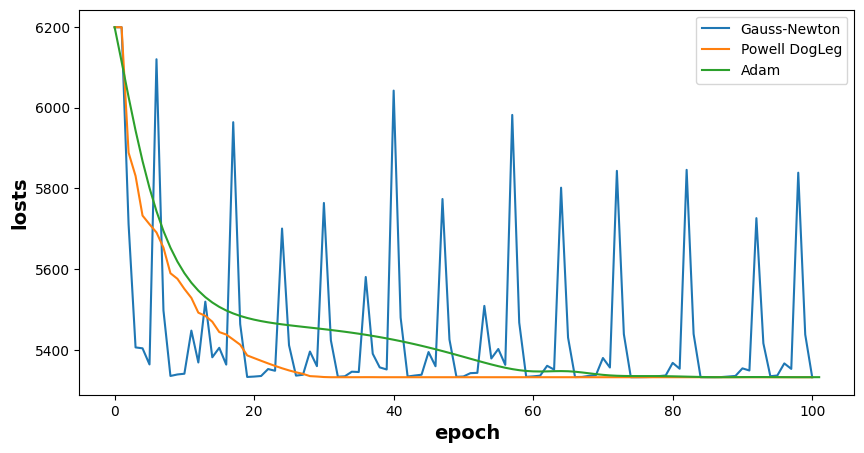

<Figure size 1000x500 with 0 Axes>

In [ ]:
###LOSTS/EPOCH

def f1(X, b):
  return ((X * b[0]) / (b[1] + X))


b01 = np.array([10.0, 1.0])
answer = np.array([2.0, -2.0]) #итоговый ответ
x1, y1 = gen_random_points_f(f1, answer, 40, dispx=20, disp=1, shiftx=1)

x = x1.copy()
y = y1.copy()
b0 = b01.copy()

b, points, s_array, cur_epoch = method_Gauss_Newton(f1, x, y, b0, 100, 0)
print(b, cur_epoch)

plt.plot(s_array, label=f"Gauss-Newton")


####
x = x1.copy()
y = y1.copy()
b0 = b01.copy()

b, points, s_array, cur_epoch = method_Powell_Dog_Leg(f1, x, y, b0, 1, 100, 0)
print(b, cur_epoch)
plt.plot(s_array, label=f"Powell DogLeg")

####(без копирования проблема со ссылками)
x = x1.copy()
y = y1.copy()
b0 = b01.copy()

# b, cur_epoch, s_array = solve_not_linear_regression_with_gradient_descent(f1, x, y, b0, 100, eps_stop=0.1, flag=True)
# print(b, cur_epoch)
# plt.plot(s_array, label=f"GD")


####
x = x1.copy()
y = y1.copy()
b0 = b01.copy()

W, weights_paint, losts, cur_epoch = SGD_Adam(f1, x, y, b0, 0.1, epochs=100, eps_stop=0)

print(W, cur_epoch)
plt.plot(losts, label=f"Adam")



plt.legend()
plt.ylabel("losts", fontsize=14, fontweight="bold")
plt.xlabel("epoch", fontsize=14, fontweight="bold")
plt.show()
plt.tight_layout() # Выравнивание

##**Исследование скорости сходимости и решения регресии для Gauss Newton, Powell Dogleg, GD и Adam.**

SGD - использует случайные градиенты, поэтому сходится медленнее. Он не учитывает предыдущие шаги и поэтому хоть он и медленный, он единственный, кто на всех трех экспериментах показал ровный график. Осстальные три являются алгоритмами второго порядка, из-за чего модель может оказаться неточной на ранних итерациях. Они так же могут начать блуждать при плохом начальном приближении, ведь они все делают большие и нелинейные шаги. И последним фактором, который может сказаться на колебании функции потерь является подбор аргументов, который уникален для каждой задачи. Итого мы получили, что они могут "заплутать", но на практике они обычно показывают себя быстрее. Так, Adam использует экспоненциальное сглаживание предыдущих градиентов. Gauss-Newton - опирается на модель второго порядка, основанную на якобиане, что делает его бысттрее. А Powell Dogleg является модификацией последнего, и может делать шаги в точности как он, а может использовать для пересчета новый параметр радиус, который позволяет решать некоторые задачи быстрее, но сильно зависит от подбора параметров и начальных значений.

Теперь посмотрим как это влияет на решение задач нелинейной регрессии. На самом деле связь проста, хоть некоторые алгоритмы и могут колебаться при уменьшении функции потерь, как правило они все равно находят минимум, а значит "качество" решения сводится к скорости алгоритма, а тут побеждают Gauss Newton и Powell Dogleg с попеременным успехом.

In [ ]:
##################################################################################################
###
#2

##**№2)BFGS и предыдущие методы минимизации ф-ций.**

Проделаем в целом два двойственных ряда экспериментов, в первом будем минимизировать функции, а во втором на основе минимизации $MSE$ решать регрессии.

####**Обычный SGD из ЛР2 (переделанный на решение минимизации произвольной квадратичной ф-ции).**

In [ ]:
# def H(W):
#   return sum((f(W) - Y) ** 2)

# def gradH(f, gradF, X, Y, W):
#   m = Y.shape[0]
#   return 1/m * 2 * (f(X, W) - Y) @ gradF(W)

def SGD(
    H, W, lr, epochs, eps_stop = 1e-5, eps_grad=1e-5, is_plot = False,
    start_linspace=-1, stop_linspace=1, num=25, custom_plt=plt
     ):
  cur = W
  vals = [H(W)]
  points = [cur]
  gradH = nd.Gradient(H)
  i = 0
  while (i < epochs and (i == 0 or abs(H(cur) - H(points[i - 1])) > eps_stop)):
    cur = cur - lr * gradH(cur)
    points.append(cur)
    vals.append(H(cur))
    i+=1
  # print("number of steps: ", f(cur))
  if is_plot:
    print_gradient_work(np.array(points), H, custom_plt=custom_plt, title="SGD")
  return cur, H(cur), i, vals

print(SGD(lambda w : (w[0] + w[1] - 1) ** 2, np.array([5, 5]), 0.1, 100))


def f2(W):
  return W[0] ** 2 + W[1] ** 2

def H1(W):
  return (f2(W) - 1) ** 2

W = np.array([5.0, 5.0])

# print(SGD(lambda w : (w[0] + w[1] - 1) ** 2, W, 0.1, 100, 0)[0])
print(gradient_descent_with_bin_search(H1, W, 100)[0])

(array([0.5007617, 0.5007617]), 2.320745579660621e-06, 17, [81, 29.16000000000002, 10.497600000000002, 3.7791359999999896, 1.3604889599999883, 0.48977602559999195, 0.17631936921599725, 0.06347497291775905, 0.02285099025039326, 0.008226356490141565, 0.0029614883364509634, 0.0010661358011223468, 0.00038380888840404664, 0.00013817119982545886, 4.974163193716457e-05, 1.7906987497379245e-05, 6.446515499056528e-06, 2.320745579660621e-06])
[0.70709382 0.70709382]


##**№2.1) BFGS**

В целом метод основон на все том же определнии вектора поиска как $p_k = -C_k * Δf(x_k)$, где $C_k-$обратный гессиан (вообще обычный гессиан обозначают $H_k$, а приближенный далее $B_k$).

Далее можно (и в классическом BFGS имеено так и реализовано) применить линейный поиск вдоль данного направления (например условиями Вольфа) и найти оптимальный коэффициент шага $α$

И стандартным образом пересчитать точку $x_{k + 1} = x_k + \alpha \cdot p_k$

Усложненность и хитрость же алгоритма в том, что он не считает гессиан явным образом. Для его приблизительного пересчета заводятся следующие последовательности:

$s_k = x_{k + 1} - x_{k}$

$y_k = Δf(x_{k+1}) - Δf(x_k)$

$ρ_k = \frac{1}{y_k^Ts_k}$

Приближение же опять задаем исходя из аппроксимации обратных гессианов и якобианов.

Выглядит же пересчет в удобной форме без явного счета якобианов следующим образом (стандартный квазиньютоновский метод вводящий сходящуюся последовательность матриц с удобным разложением, аппроксимирующую гессиан с точностью ряда Тейлора до второго члена):

$B_{k+1} = B_k - \frac{B_ks_ks_k^TB_k^T}{s_k^TB_ks_k} + \frac{\|y_k\|^2}{y_k^Ts_k}$

**В форме сразу пересчета обратной матрицы ($invB = C$) это можно записать следующим образом:**

$C_{k+1} = (I - ρ_ks_ky_k^T)C_k(I-ρ_ky_ks_k^T) + ρ_k\|s_k\|^2$

где $I-$единичная.





In [ ]:
#####BFGS

def method_BFGS(f, x0, epochs, eps_stop):
  gradient_function = nd.Gradient(f)
  points = [x0]
  vals = [f(x0)]


  I = np.eye(len(x0))

  invB = np.linalg.inv(I)

  x = x0
  grF = gradient_function(x0)


  cur_epoch = 0
  while(cur_epoch < epochs and np.linalg.norm(grF) > eps_stop):
    cur_epoch += 1

    #Вектор поиска
    p = -invB @ grF

    #Условия Вольфа
    alpha = sp.optimize.line_search(f, gradient_function, x, p)[0]

    s = alpha * p

    #Пересчет текущей точки-ответа
    x = x + s

    #Пересчет градиента
    grFLast = grF
    grF = gradient_function(np.array(x).tolist())

    #вспомогательные величины для пересчета обратной к приближенному гессиану B (т.е invB)
    y = grF - grFLast
    r = 1 / (y.T @ s)

    #Пересчет invB - обратного гессиана
    invB = (I - r * s @ y.T) @ invB @ (I - r * y @ s.T) + r * s @ s.T

    points.append(x.copy())
    vals.append(f(x))



  return x, np.array(points), vals




##**№2.2) Сравнение сходимости BFGS с раннее реализованными методами.**

[-0.07124902  0.00048901]
-0.03563882789271009
[-0.04240966  0.34162535]


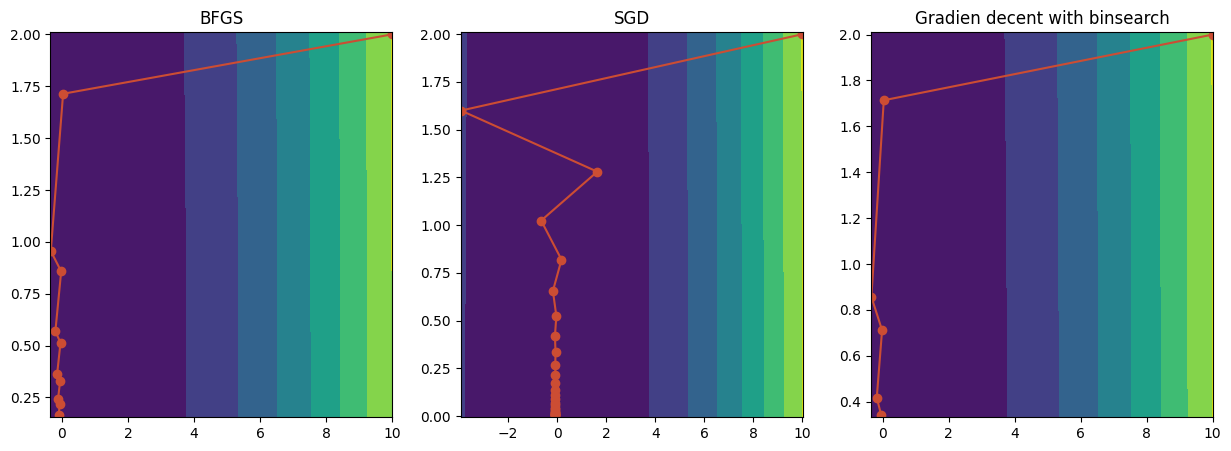

In [ ]:
plt.rcParams["figure.figsize"] = (15, 5)

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3)

def fun(x):
  return 7 * x[0] ** 2 + x[1] ** 2 + np.sin(x[0])

start_w = np.array([10, 2])

print(method_BFGS(fun, start_w, 100, 0.001)[0])
print_gradient_work(method_BFGS(fun, start_w, 10, 0.001)[1], fun, custom_plt=ax1, title="BFGS")

print(SGD(fun, start_w, 0.1, 100, is_plot=True, custom_plt=ax2)[1])

print(gradient_descent_with_bin_search(fun, start_w, 100, eps_stop=0.1, is_plot=True, custom_plt=ax3)[0])

[ 0.084567   -0.00042503]
360.54261611529506
[ 4.10695829e-02 -8.89264038e-05]


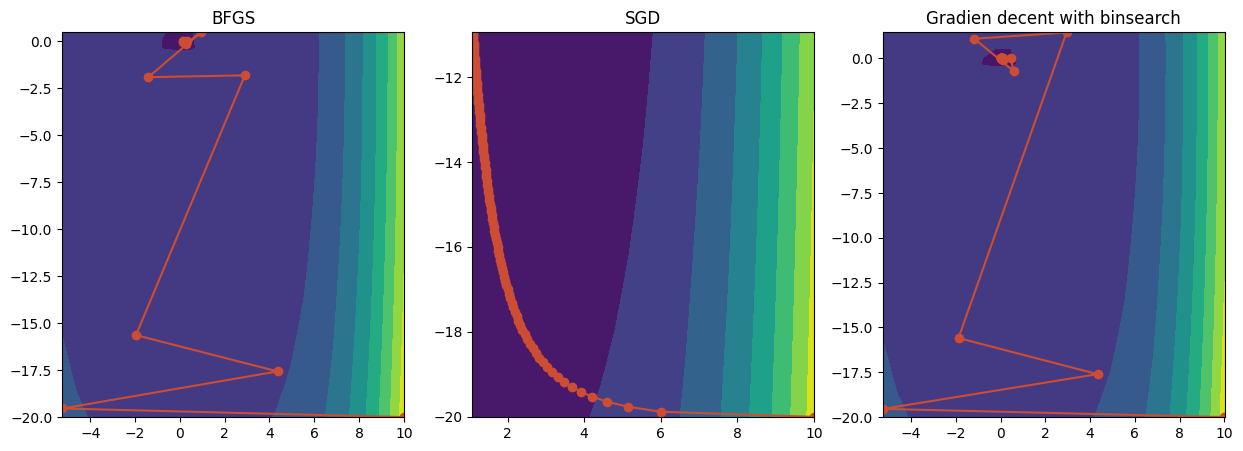

In [ ]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3)

def fun(x):
  return  3 * x[1] ** 2 + x[0] ** 4 - 1

start_w = np.array([10, -20])

print(method_BFGS(fun, start_w, 100, 0.001)[0])
print_gradient_work(method_BFGS(fun, start_w, 10, 0.001)[1], fun, custom_plt=ax1, title="BFGS")

print(SGD(fun, start_w, 0.001, 100, is_plot=True, custom_plt=ax2)[1])

print(gradient_descent_with_bin_search(fun, start_w, 100, eps_stop=0.1, is_plot=True, custom_plt=ax3)[0])

[ 8.36095349e-04 -1.00046177e+00]
1.6841313428082987e-05
[-0.2908651  -1.12111232]


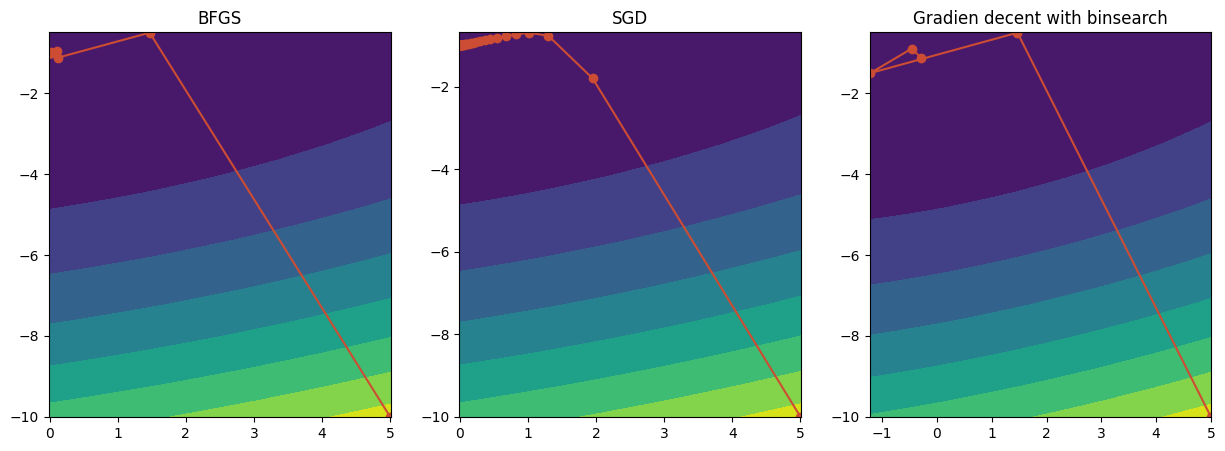

In [ ]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3)

def fun(x):
  return  (2 * x[1] - 0.5 * x[0] + 2) ** 2 + x[0] ** 2

start_w = np.array([5, -10])

print(method_BFGS(fun, start_w, 10, 0.001)[0])
print_gradient_work(method_BFGS(fun, start_w, 10, 0.001)[1], fun, custom_plt=ax1, title="BFGS")

print(SGD(fun, start_w, 0.1, 100, is_plot=True, custom_plt=ax2)[1])

print(gradient_descent_with_bin_search(fun, start_w, 100, eps_stop=0.1, is_plot=True, custom_plt=ax3)[0])

##**Исследование траектории для BFGS, SGD и gradient descent with binsearch.**

Заметим, что для SGD график является более прямым(гладким), что особенно видно во втором эксперименте, где траектория является параболой. Это связано с тем, что шаг определяется фиксированной степенью обучения.

У градиентного спуска траектория становится более ломаной из-за того, что шаг оптимизируется на каждом пересчете. За счет этого он сходится быстрее, но это все равно не достаточное улучшение.

Траектория BFGS является самой сложной из всех трех, ведь он использует информацию о предыдущих шагах. Благодоря этому он может достигать минимума быстрее.

**Вывод:**

Как итог BFGS работает быстрее и имеет самый не "гладкий" путь траектории, а связано это с самым "точным" пересчетом шага, а именно с использованием предыдушей информации о поиске минимума. Но в такой траектории есть и свои минусы, так главный из них - если начать из сильно удаленной точки алгоритм может заблудиться.

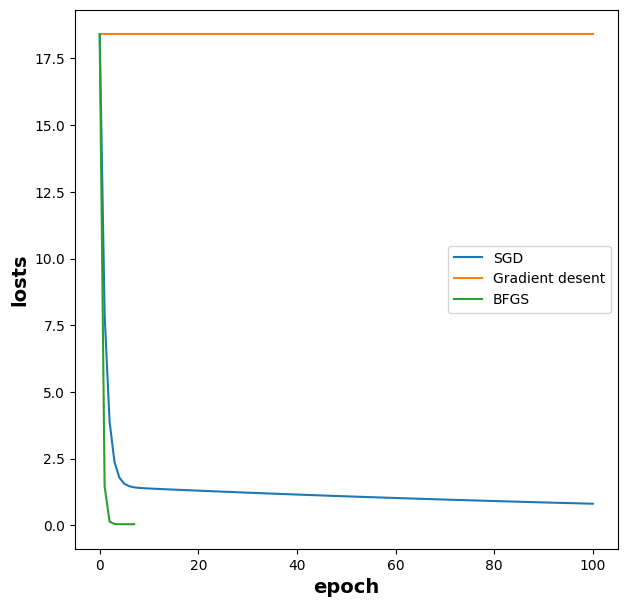

<Figure size 700x700 with 0 Axes>

In [ ]:
plt.rcParams["figure.figsize"] = (7, 7)

def f1(X, b):
  return b[0] * np.sin(X ** 3) + b[1] * (X ** 2) - b[0] * np.exp(X) * X + 1

b01 = np.array([2.3, 0.3])
answer = np.array([2.7, 1.1]) #итоговый ответ
x1, y1 = gen_random_points_f(f1, answer, 20, dispx=2, disp=0.1, shiftx=0)

x = x1.copy()
y = y1.copy()
b0 = b01.copy()

fun = lambda B: sum((y - f1(x, B)) ** 2)

start_w = b01

vals = SGD(fun, start_w.copy(), 0.001, 100, custom_plt=ax2)[3]
plt.plot(vals, label=f"SGD")

vals = gradient_descent_with_bin_search(fun, start_w, 100, eps_stop=0.001, custom_plt=ax3, flag=True)[2]
plt.plot(vals, label=f"Gradient desent")

_, _, vals = method_BFGS(fun, start_w.copy(), 100, 0.001)
plt.plot(vals, label=f"BFGS")

plt.legend()
plt.ylabel("losts", fontsize=14, fontweight="bold")
plt.xlabel("epoch", fontsize=14, fontweight="bold")
plt.show()
plt.tight_layout() # Выравнивание

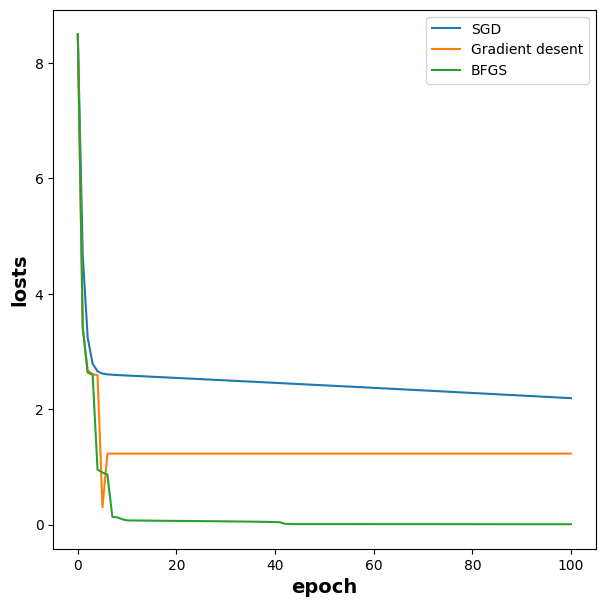

<Figure size 700x700 with 0 Axes>

In [ ]:
def fun(x):
  return  (1 - x[0]) ** 2 + 100 * (x[1] - x[0] ** 2) ** 2

start_w = np.array([-0.5, 0.5])

vals = SGD(fun, start_w.copy(), 0.001, 100, is_plot=True, custom_plt=ax2)[3]
plt.plot(vals, label=f"SGD")

vals = gradient_descent_with_bin_search(fun, start_w, 100, eps_stop=0.001, is_plot=True, custom_plt=ax3, flag=True)[2]
plt.plot(vals, label=f"Gradient desent")

_, _, vals = method_BFGS(fun, start_w.copy(), 100, 0.001)
plt.plot(vals, label=f"BFGS")

plt.legend()
plt.ylabel("losts", fontsize=14, fontweight="bold")
plt.xlabel("epoch", fontsize=14, fontweight="bold")
plt.show()
plt.tight_layout() # Выравнивание

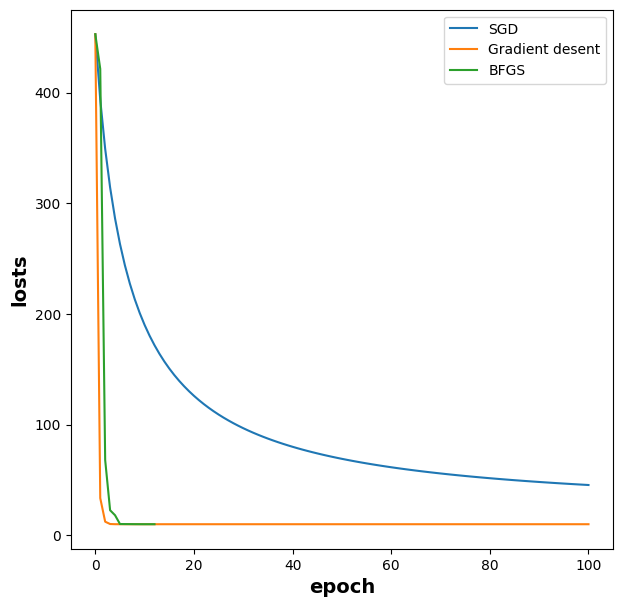

<Figure size 700x700 with 0 Axes>

In [ ]:
def fun(x):
  return 0.3 * x[1] ** 2 + np.exp(0.6 * x[0] + 3) + x[0] ** 2

start_w = np.array([5, 9])

vals = SGD(fun, start_w.copy(), 0.001, 100, is_plot=True, custom_plt=ax2)[3]
plt.plot(vals, label=f"SGD")

vals = gradient_descent_with_bin_search(fun, start_w, 100, eps_stop=0.001, is_plot=True, custom_plt=ax3, flag=True)[2]
plt.plot(vals, label=f"Gradient desent")

_, _, vals = method_BFGS(fun, start_w.copy(), 100, 0.001)
plt.plot(vals, label=f"BFGS")

plt.legend()
plt.ylabel("losts", fontsize=14, fontweight="bold")
plt.xlabel("epoch", fontsize=14, fontweight="bold")
plt.show()
plt.tight_layout() # Выравнивание

##**Исследование скорости сходимости для BFGS, SGD и gradient descent with binsearch.**

Заметим, что самый ровный график - это график SGD, ведь его траектория самая ровная, и из-за небольших шагов он не сбивается с "правильного пути", но опять же, из за маленьких шагов он медленный. Мы можем видеть, что он не успевает дойти до "хорошей" точности и упираеться в количество шагов.

У BFGS и gradient descent with binsearch могут случатся перепады, и из-за них второй например вообще может не найти минимум. У BFGS расхождения не случаются, но могут быть шаги, которые плохо приближают к минимуму, но все равно не мешают алгоритму найти минимум.

**Вывод:**

Все три алгоритма на практике сходятся к минимуму, но SGD слишком медленный и не достигает результата, gradient descent with binsearch слишком нестабильный из-за нелинейной траектории и относительно непресказуемого изменения шага, а BFGS быстрее всех из-за пересчета на каждом ходу и находит минимум, ведь для пересчета использует предыдущие шаги.

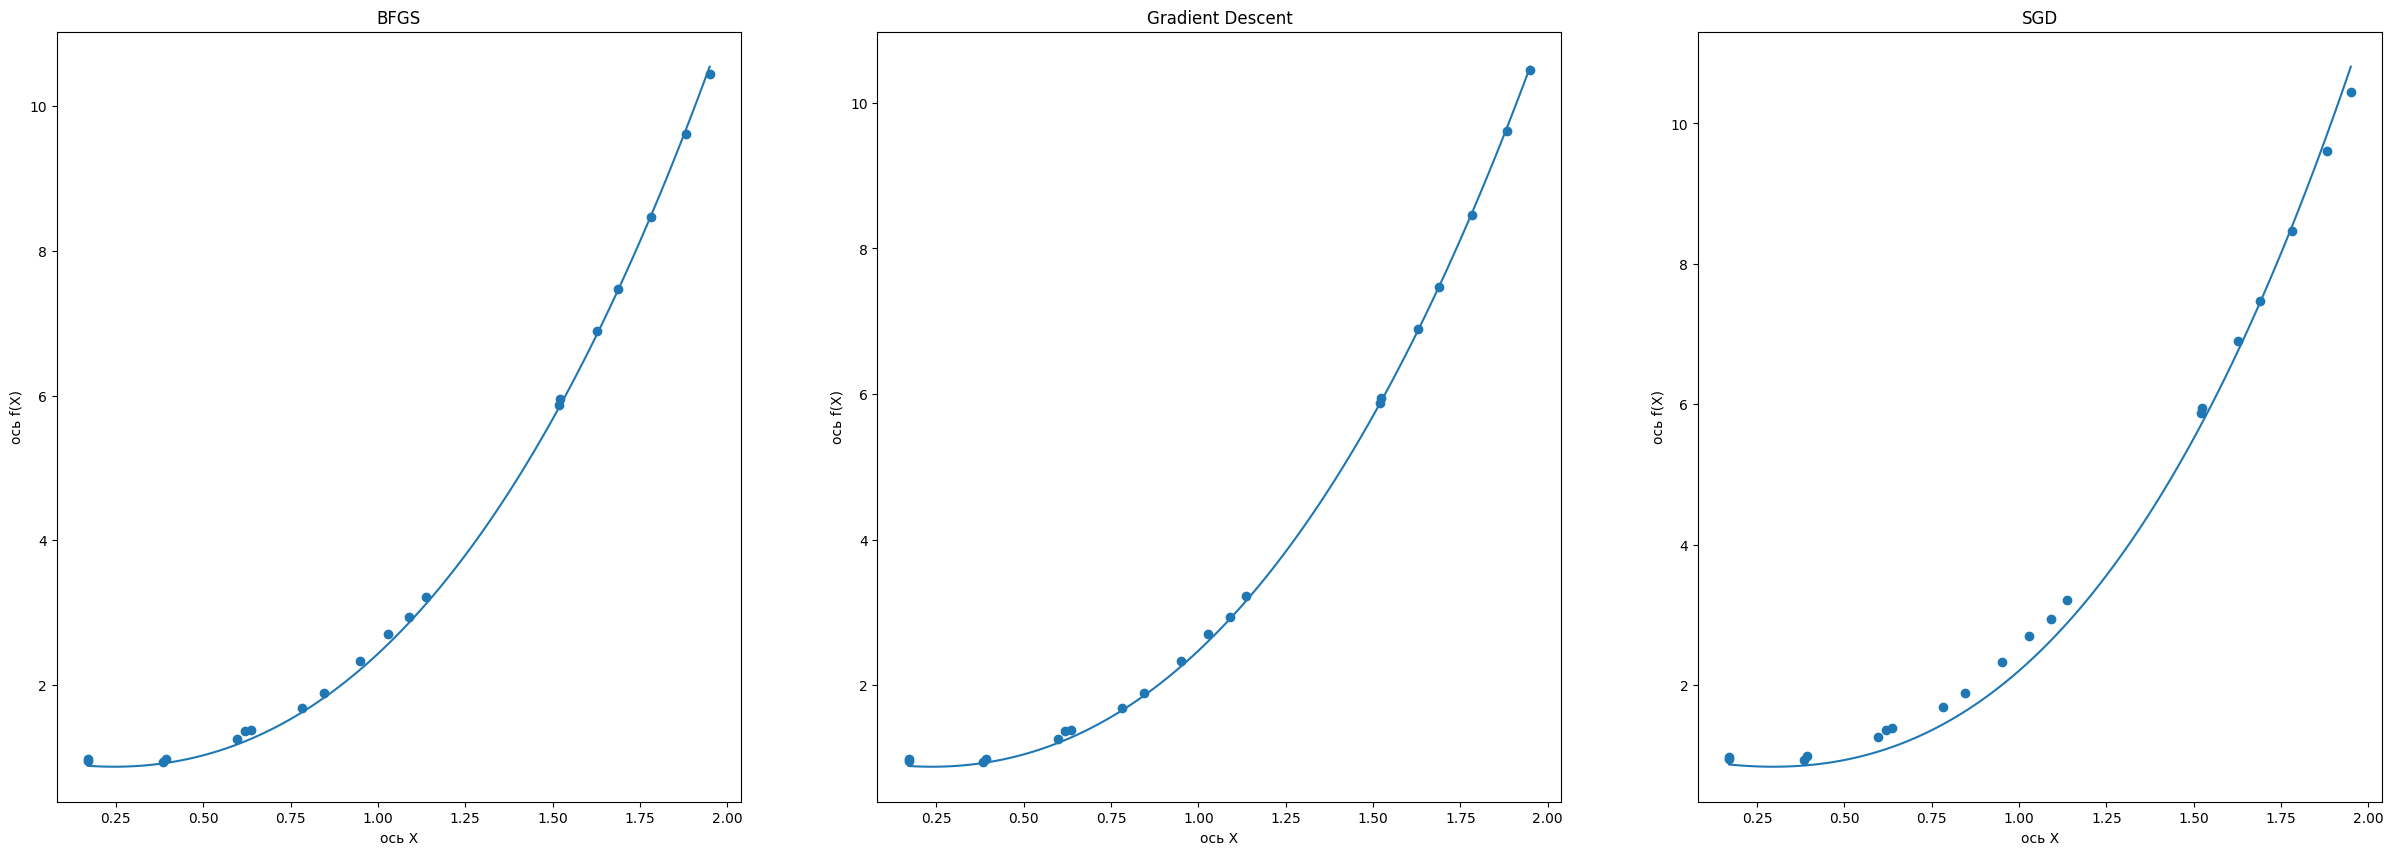

In [ ]:
plt.rcParams["figure.figsize"] = (30, 10)
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3)

def f1(X, b):
  return b[0] * (X ** 3) + b[1] * (X ** 2) - X + 1

b01 = np.array([1.0, 1.0])
answer = np.array([0.5, 2.0]) #итоговый ответ
x1, y1 = gen_random_points_f(f1, answer, 20, dispx=2, disp=0.1, shiftx=0)

x = x1.copy()
y = y1.copy()
b0 = b01.copy()

S = lambda B: sum((y - f1(x, B)) ** 2)

b = method_BFGS(S, b0, 100, 0.001)[0]
print_example_work(x, y, f1, b, title="BFGS", custom_plt=ax1)

b = gradient_descent_with_bin_search(S, b0, 100, eps_stop=0.001, custom_plt=ax3, flag=True)[0]
print_example_work(x, y, f1, b, title="Gradient Descent", custom_plt=ax2)

b = SGD(S, b0, 0.001, 100, custom_plt=ax2)[0]
print_example_work(x, y, f1, b, title="SGD", custom_plt=ax3)

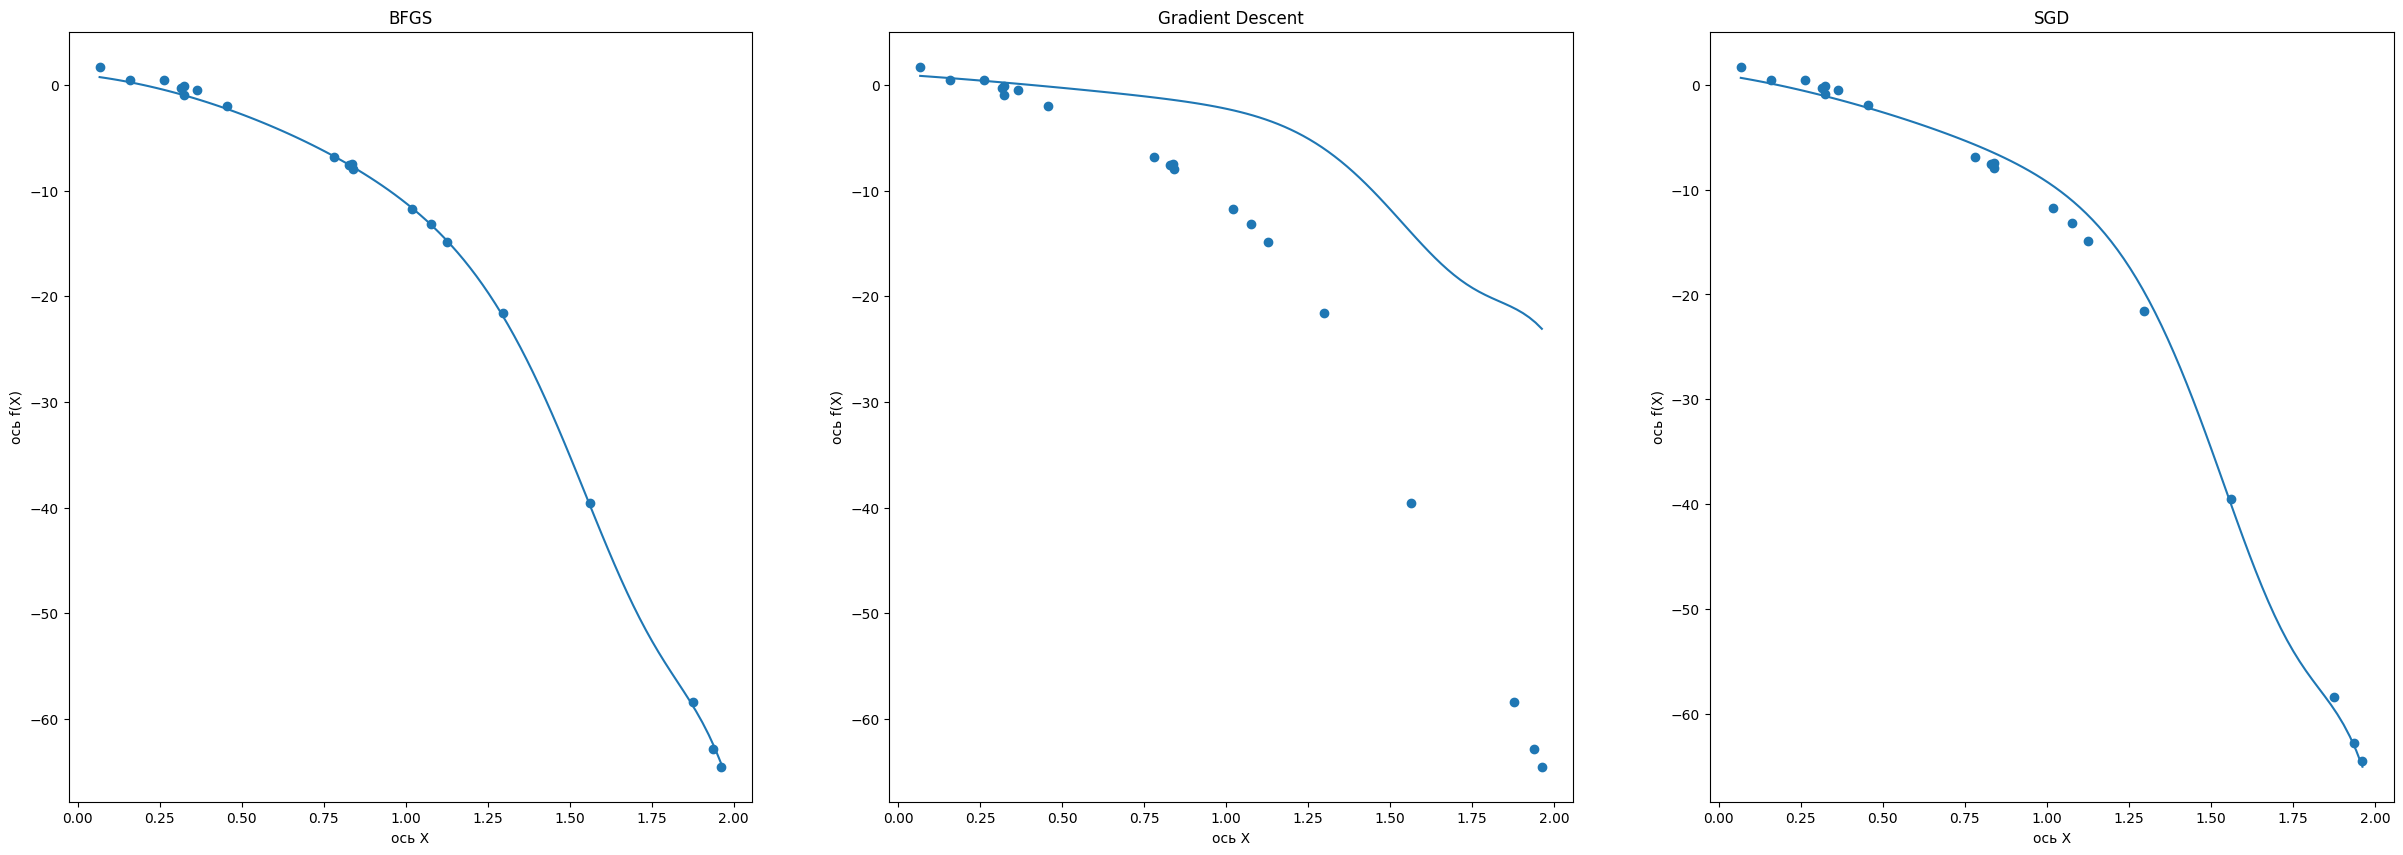

In [ ]:
def f1(X, b):
  return b[0] * np.sin(X ** 3) + b[1] * (X ** 2) - b[0] * np.exp(X) * X + 1

plt.rcParams["figure.figsize"] = (30, 10)
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3)

b01 = np.array([2.0, 0.5])
answer = np.array([3.0, -7.0]) #итоговый ответ
x1, y1 = gen_random_points_f(f1, answer, 20, dispx=2, disp=1, shiftx=0)

x = x1.copy()
y = y1.copy()
b0 = b01.copy()

S = lambda B: sum((y - f1(x, B)) ** 2)

b = method_BFGS(S, b0, 100, 0.001)[0]
print_example_work(x, y, f1, b, title="BFGS", custom_plt=ax1)

x = x1.copy()
y = y1.copy()
b0 = b01.copy()

b = gradient_descent_with_bin_search(S, b0, 100, eps_stop=0.001, custom_plt=ax3, flag=True)[0]
print_example_work(x, y, f1, b, title="Gradient Descent", custom_plt=ax2)

x = x1.copy()
y = y1.copy()
b0 = b01.copy()

b = SGD(S, b0, 0.001, 100, custom_plt=ax2)[0]
print_example_work(x, y, f1, b, title="SGD", custom_plt=ax3)

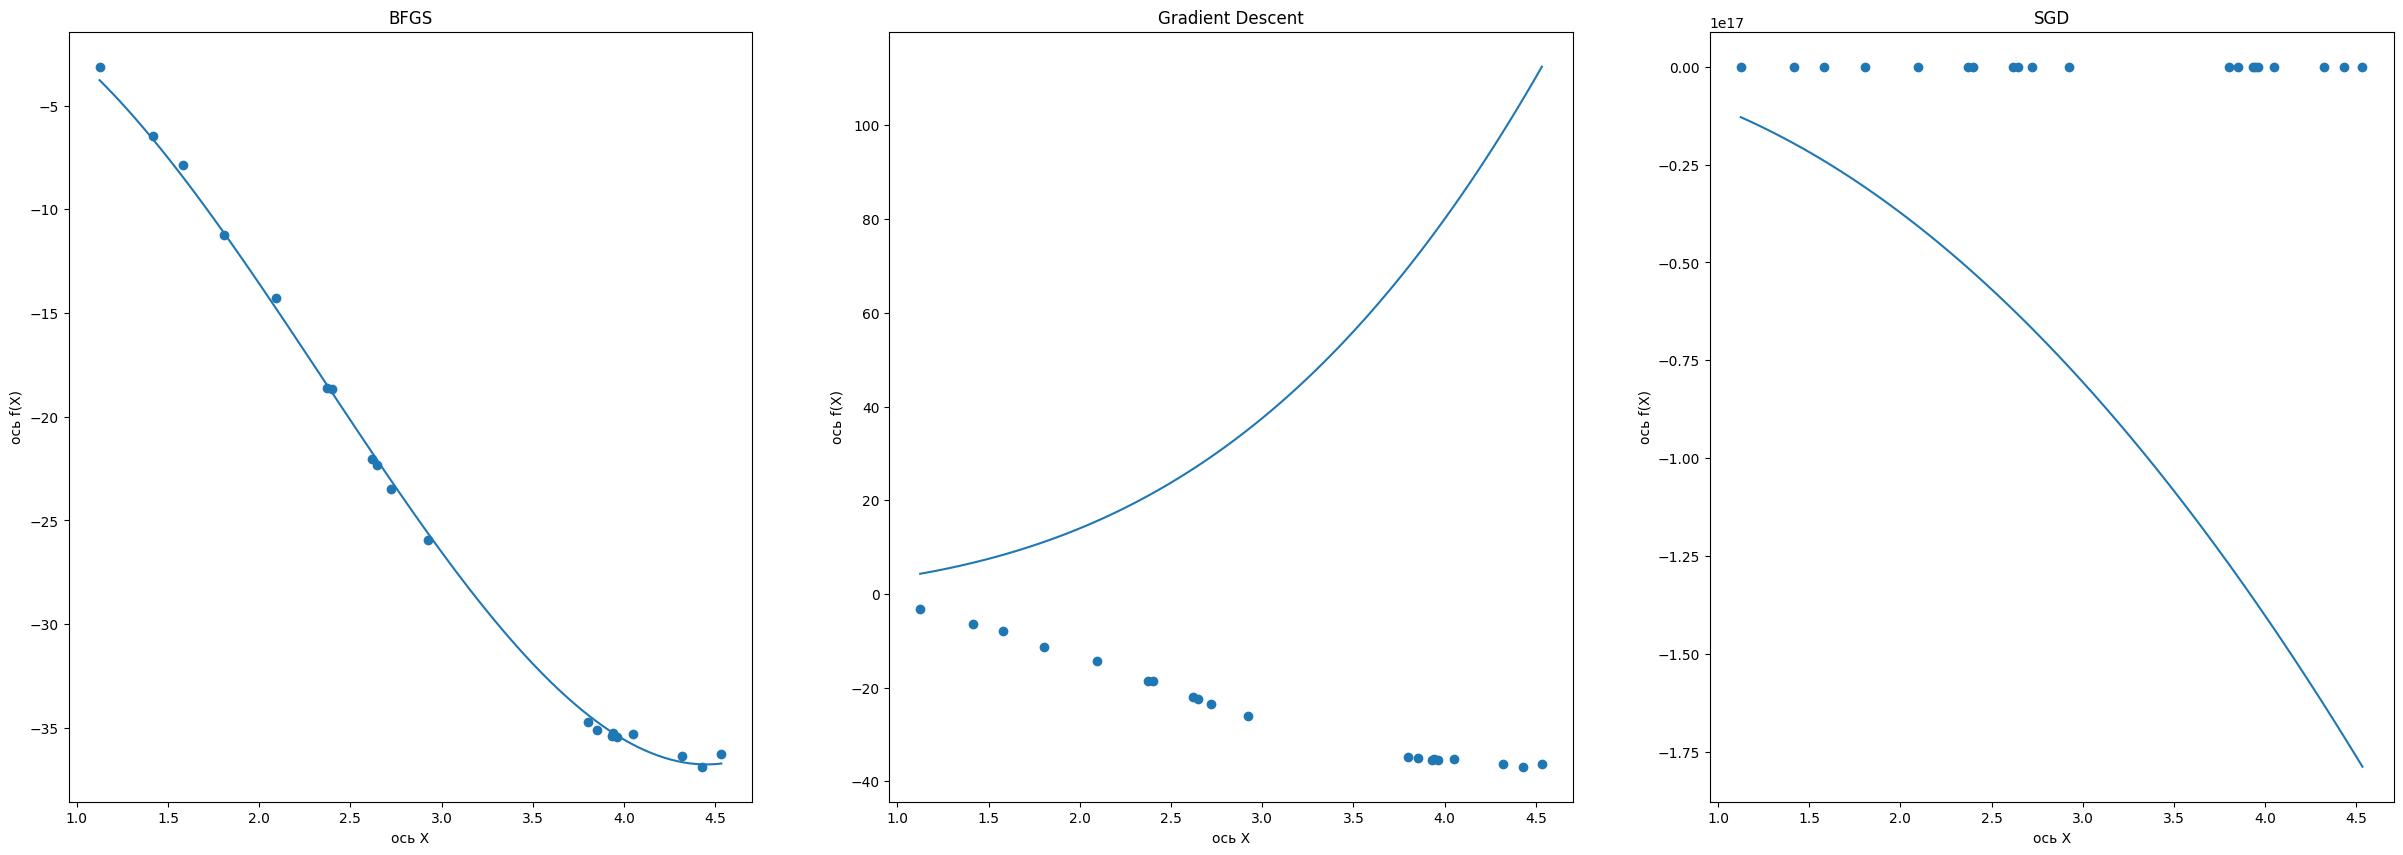

In [ ]:
def f1(X, b):
  return b[0] * X + b[1] * X ** 2 + X ** 3

plt.rcParams["figure.figsize"] = (30, 10)
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3)

b01 = np.array([2.0, 0.5])
answer = np.array([3.0, -7.0]) #итоговый ответ
x1, y1 = gen_random_points_f(f1, answer, 20, dispx=5, disp=1, shiftx=1)

x = x1.copy()
y = y1.copy()
b0 = b01.copy()

S = lambda B: sum((y - f1(x, B)) ** 2)

b = method_BFGS(S, b0, 100, 0.001)[0]
print_example_work(x, y, f1, b, title="BFGS", custom_plt=ax1)

x = x1.copy()
y = y1.copy()
b0 = b01.copy()

b = gradient_descent_with_bin_search(S, b0, 100, eps_stop=0.001, custom_plt=ax3, flag=True)[0]
print_example_work(x, y, f1, b, title="Gradient Descent", custom_plt=ax2)

x = x1.copy()
y = y1.copy()
b0 = b01.copy()

b = SGD(S, b0, 0.001, 100, custom_plt=ax2)[0]
print_example_work(x, y, f1, b, title="SGD", custom_plt=ax3)

##**Исследование решения задачи нелинейной регресии для BFGS, SGD и gradient descent with binsearch.**

Наконец узнаем как алгоритмы справляются с решением регресии. Результат на самом деле понятен уже с предыдущих экспериментов, но следует обобщить все еще раз. Лучше всего себя показывает BFGS, который смог единственный восстанивить функцию во всех трех случаях, ведь он надежный из-за того, что опирается на все предыдущие шаги, и из-за этого он не может сделать шаг не туда, ведь его движение задается всеми шагами. Этого не сказать про gradient descent with binsearch, и хоть ему хватает скорости для поиска регресии, он как раз может выбрать не то направление и выдать совершено не тот результат, который мы ждали, что лучше всего демонстрирует третий эксперимент. SGD просто не успевает решить задачу за отведенное число итераций, из-за чего в первых двух экспериментах он хоть и решает регрессию, мы можем увидеть ее неточность относительно других методов, а в последнем он и вовсе не успевает дойти даже до приблезитьльного ответа.

**Вывод:**

Все три алгоритма могут решать задачу нелинейной регресии, но в силу скорости из-за пересчета шага и стабильности из-за учета предыдущих шагов BFGS справляется лучше всех.